<a href="https://colab.research.google.com/github/zhongjie-wu/579project/blob/main/Nash_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download libraries
# ! pip install pettingzoo[mpe]

In [2]:
# import necessary libraries
from pettingzoo.mpe import simple_speaker_listener_v3, simple_reference_v2, simple_world_comm_v2
import numpy as np
import matplotlib.pyplot as plt
from DQNAgent import *
from tqdm import tqdm

# Nash Q-Learning for Simple Speaker Listener Environment

### Helper Functions

In [3]:
# Helper methods
def listener_bin_init(bounds = [(-2, 2),(-4, 4)], step_size=0.05):
    '''
    (x_vel, y_vel, land1_x, land1_y, land2_x, land2_y, land3_x, land3_y, spearker_cmd0, spearker_cmd1, spearker_cmd2)
    '''
    discretized_state = [0 for i in range(8)]
    for i in range(2):
        discretized_state[i] = np.linspace(bounds[0][0], bounds[0][1], int((bounds[0][1] - bounds[0][0])/step_size) + 1)
        
    for i in range(2, 8):
        discretized_state[i] = np.linspace(bounds[1][0], bounds[1][1], int((bounds[1][1] - bounds[1][0])/step_size) + 1)

    return tuple(discretized_state)

def listener_encode_state(observation, discretized_state=listener_bin_init()):
    # encode x,y velocity
    index = np.zeros(8)
    result = []
    for i in range(8):
        idx = np.digitize([observation[i]], discretized_state[i])
        index[i] = idx - 1
        if i < 2:
            result += [1 if i == idx else 0 for i in range(81)]
        else:
            result += [1 if i == idx else 0 for i in range(161)]
    for i in range(8, 11):
        result.append(observation[i])
    return np.array(result)

def speaker_encode_state(observation):
    return np.array([float(i == np.argmax(observation)) for i in range(len(observation))])

def weight_init(size: tuple):
    return np.random.uniform(-0.000001, 0.000001, size)

def eps_greedy_act_selection(epsilon, w, state, is_speaker):
    num_choices = w.shape[0]
    if np.random.random() < epsilon:
        action = np.random.randint(0, num_choices)
    else:
        result = np.dot(w, state)
        action = np.argmax(result)

    A_speaker, A_listener = np.unravel_index(action, (3, 5))
    return A_speaker if is_speaker else A_listener

### Nash Q-Learning

In [4]:
AGENT_NAMES = ['speaker_0', 'listener_0']
AGENT_INFOS = {
    name:
        {
            "state_space_size": 3 if name == 'speaker_0' else 11, 
            "action_space_size": 3 if name == 'speaker_0' else 5 
        } for name in AGENT_NAMES
}

class NashQ:
    def __init__(self, episode=100, alpha=0.01, gamma=0.99, epsilon = 0.2, decay = 0.99975, num_cycles=25):
        # Initialize the environment, weights for both agentsm and all other hyperparameters
        self.w_speaker = weight_init((15, 3))
        self.w_listener = weight_init((15, 1131))

        self.env = simple_speaker_listener_v3.env(max_cycles=num_cycles, continuous_actions=False)

        self.episode = episode
        self.alpha = alpha
        self.gamma = gamma
        self.num_cycles = num_cycles
        self.epsilon = epsilon
        self.decay = decay

        self.joint_action = np.array(
            [[0, 1, 2, 3, 4],
            [5, 6, 7, 8, 9],
            [10, 11, 12, 13, 14]]
        )

    def train(self):
        self.all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
        for episode in tqdm(range(1, self.episode + 1), ascii=True, unit='episodes'):
            # Reset the environment
            self.env.reset()

            # Observe the initial states for both agents and perform encoding
            S_speaker = self.env.observe('speaker_0')
            S_listener = self.env.observe('listener_0')
            phi_speaker = speaker_encode_state(S_speaker)
            phi_listener = listener_encode_state(S_listener)

            # Initialize step related info for both agents
            S_next_speaker = None
            phi_next_speaker = None
            S_next_listener = None
            phi_next_listener = None
            
            update_counter = 0
            A_speaker = None
            A_listener = None
            R_speaker = None
            R_listener = None

            eps = self.epsilon
            for agent in self.env.agent_iter():
                if agent == 'speaker_0':
                    update_counter += 1
                    if self.env.truncations[agent] == True or self.env.terminations[agent] == True:
                        self.env.step(None)
                    else:
                        # Action selection
                        A_speaker = eps_greedy_act_selection(eps, self.w_speaker, phi_speaker, is_speaker = True)
                        self.env.step(A_speaker) 
                        _, R_speaker, termination, truncation, info = self.env.last()
                        S_next_speaker = self.env.observe(agent)
                        phi_next_speaker = speaker_encode_state(S_next_speaker)

                else:
                    update_counter += 1
                    if self.env.truncations[agent] == True or self.env.terminations[agent] == True:
                        self.env.step(None)
                    else:
                        # Action selection
                        A_listener = eps_greedy_act_selection(eps, self.w_listener, phi_listener, is_speaker = False)
                        self.env.step(A_listener) 
                        _, R_listener, termination, truncation, info = self.env.last()
                        S_next_listener = self.env.observe(agent)
                        phi_next_listener = listener_encode_state(S_next_listener)


                # Perform update for the Q after each agent gets to take a step
                if update_counter == 2:
                    collected_action = self.joint_action[A_speaker, A_listener]

                    if self.env.truncations['speaker_0'] or self.env.truncations['speaker_0'] or self.env.terminations['listener_0'] or self.env.terminations['listener_0']:
                        # Update rule if terminated or truncated
                        self.w_speaker = self.w_speaker + self.alpha*(R_speaker - np.dot(self.w_speaker, phi_speaker)[collected_action])*phi_speaker
                        self.w_listener = self.w_listener + self.alpha*(R_listener - np.dot(self.w_listener, phi_listener)[collected_action])*phi_listener
                        self.all_rewards['speaker_0'].append(R_speaker)
                        self.all_rewards['listener_0'].append(R_listener)
                        continue
                    else:
                        # General update rule
                        Q_nash_speaker = np.max(np.dot(self.w_speaker, phi_next_speaker))
                        Q_nash_listener = np.max(np.dot(self.w_listener, phi_next_listener))
                        self.w_speaker = self.w_speaker + self.alpha * (R_speaker + self.gamma*Q_nash_speaker - np.dot(self.w_speaker, phi_speaker)[collected_action]) * phi_speaker
                        self.w_listener = self.w_listener + self.alpha * (R_listener + self.gamma*Q_nash_listener - np.dot(self.w_listener, phi_listener)[collected_action]) * phi_listener
                        phi_speaker = phi_next_speaker
                        phi_listener = phi_next_listener

                    # Reset the counter to 0
                    update_counter = 0

            eps = eps * self.decay
                
    


In [5]:
nash = NashQ(episode=1000, alpha=0.001, gamma=0.99, epsilon = 0.2, decay = 0.99975, num_cycles=25)
nash.train()

100%|##########| 1000/1000 [00:24<00:00, 40.36episodes/s]


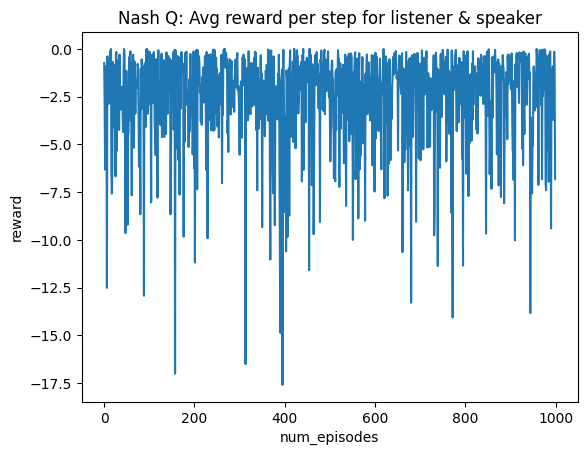

In [8]:
plt.plot(range(1000), nash.all_rewards['listener_0'])
plt.title('Nash Q: Avg reward per step for listener & speaker')
plt.xlabel('num_episodes')
plt.ylabel('reward')
plt.show()